# Week 4: BBC News Classification Project
## DTSA 5510 - Intro to Machine Learning - Unsupervised

In [12]:
import pandas as pd
import numpy as np
import nltk
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
# downloads required to make this notebook run

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

In [3]:
# read in data
train_df = pd.read_csv('data/BBC News Train.csv')

train_df.head(5)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### EDA & cleaning:

Make pipleline to preprocess data
* remove missing text (none in this data)
* remove duplicate text
* tokenize text
* tfidf_vectorizer, plot scores

Make pipeline to Modeling
* non-negative matrix factorization models
    * Frobenius Loss
    * Kullback-Leibler Divergence 
    * plot top words per topic
* Compare to supervised learning model

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


There are no missing values in the data.

In [5]:
# function to remove duplicates
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    # number of duplicates
    number_duplicates = df['Text'].duplicated().sum()

    # print no. duplicates
    print(f'No. of duplicate articles: {number_duplicates}' '\n')

    # removal
    df_cleaned = df.drop_duplicates(subset = ['Text'])

    return df_cleaned

In [6]:
train_df = remove_duplicates(train_df)
train_df

No. of duplicate articles: 50



,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


### Data transformers:

A uniform method is needed to preprocess the text in both the training and the testing data. 

In [17]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self,text):
        # tokenize
        tokens = word_tokenize(text)

        # remove stop words
        tokens = [word for word in tokens if word.lower() not in self.stop_words]

        # lower case
        tokens = [word.lower() for word in tokens]

        # lemmatization
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # remove non-alphabetic characters
        tokens = [word for word in tokens if word.isalpha()]
        
        # remove punctuation
        tokens = [word for word in tokens if word.isalpha()]

        # join tokens
        return ' '.join(tokens)

    # fit to data
    def fit(self, X, y = None):
        return self
        
    # transform
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_copy = X.copy()
            X_copy['Text'] = X_copy['Text'].apply(self. preprocess_text)
            return X_copy
        else:    
            raise ValueError('''Input should be data frame with a column named 'Text' ''')

### Pipeline:

In [18]:
# categorize features
text_feats = ['Text']

# specify transformers
text_transformer = make_pipeline(TextPreprocessor())

# create preprocessor
preprocessor = make_column_transformer((text_transformer, text_feats),
                                      remainder = 'passthrough')

# pipeline
processed_train_df = preprocessor.fit_transform(train_df) # this is an np array

### Vectorization

In [10]:
text = train_df['Text']

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the text data
dtm = vectorizer.fit_transform(text)

In [11]:
# Convert the sparse matrix to a dense format (only for inspection, as this can be memory-intensive)
dtm_dense = dtm.toarray()

# Get the feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for easier inspection
dtm_df = pd.DataFrame(dtm_dense, columns=feature_names)

# Display the first few rows of the matrix
dtm_df.head(5)


,ability,able,academy
0,0.0,0.0,0.0
1,0.0,0.0,0.0


In [12]:


# Sum the frequencies of each term across all documents
word_frequencies = np.sum(dtm.toarray(), axis=0)

# Create a DataFrame for the word frequencies
freq_df = pd.DataFrame({'Term': feature_names, 'Frequency': word_frequencies})

# Sort the DataFrame by frequency
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Display the top 10 most frequent words
freq_df.head(10)


,Term,Frequency
775,said,96.563156
585,mr,61.043444
995,year,49.978348
335,film,41.891714
365,game,41.090255
598,new,39.616930
650,people,37.229789
990,world,31.757189
910,time,30.988749
341,firm,30.510961


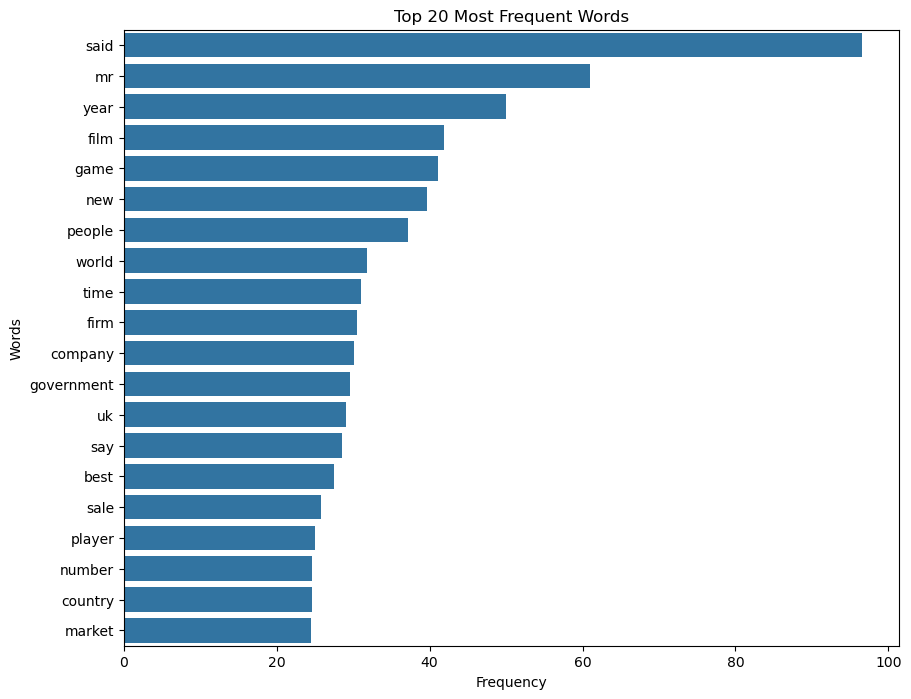

In [13]:
# Plot the top 20 most frequent words
plt.figure(figsize=(10, 8))
sns.barplot(x='Frequency', y='Term', data=freq_df.head(20))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


In [14]:
from sklearn.decomposition import NMF

# Initialize the NMF model
num_topics = 5  # Choose the number of topics
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit the model to the document-term matrix
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_


In [15]:
# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Print top terms for each topic
num_top_words = 10  # Number of top words to display for each topic
for topic_idx, topic in enumerate(H):
    top_terms_idx = topic.argsort()[-num_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx}:")
    print(" ".join(top_terms))
    print()


Topic 0:
mr labour election blair said party tory brown minister government

Topic 1:
game england player win match said cup champion wale injury

Topic 2:
film award best actor oscar star actress director festival nomination

Topic 3:
said firm company market sale growth share year economy bank

Topic 4:
mobile phone people technology music service said user software net



In [16]:
# Assign the topic with the highest score to each document
train_df['Topic'] = W.argmax(axis=1)

# Display the first few rows with assigned topics
train_df[['ArticleId', 'Category', 'Topic']].head()


,ArticleId,Category,Topic
0,1833,business,3
1,154,business,3
2,1101,business,3
3,1976,tech,4
4,917,business,3


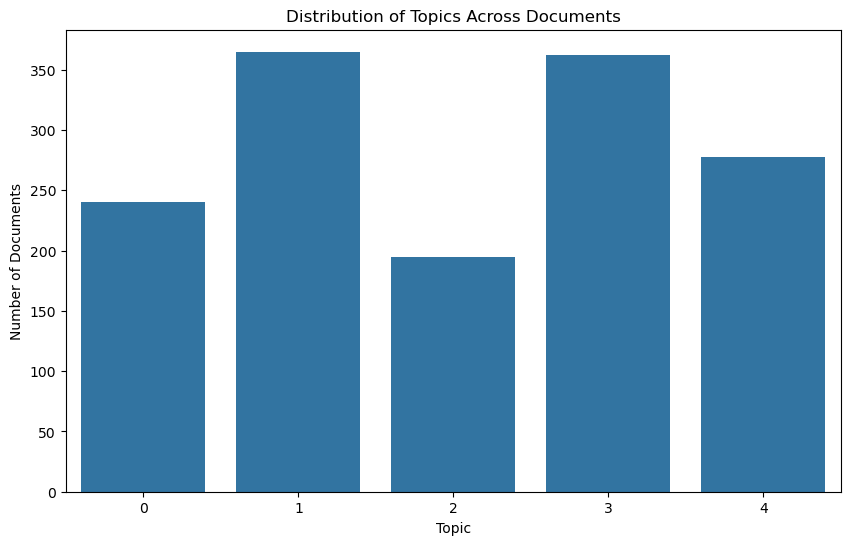

In [17]:
# Plot the distribution of topics across documents
plt.figure(figsize=(10, 6))
sns.countplot(x='Topic', data=train_df)
plt.title('Distribution of Topics Across Documents')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.show()


## References:

1. **ChatGPT.** Damn rights, I used it and not going to pretend I didn't! I already knew the structure of pipelines and preprocessors from previous ML classes (both at UC Boulder and elsewhere). I had written out code for the tokenization and thought - why don't I incorporate this into a pipeline? That's when I turned to AI for assistance. There was a lot of back and forth, because nothing ever worked the first (or 5th) time around. AI is a tool, not a crutch. I suppose a crutch _IS_ a tool, but I digress.  **TLDR; I used AI for assistance, NOT to do the work for me.**    
      
2. All course lectures, notebooks, examples, readings, and material etc. were heavily referenced throughout this entire notebook.